# SkyGeni Deal Risk Scoring Engine

## Problem Definition

SkyGeni faces a critical sales challenge: 54.7% of deals are lost, with each deal averaging $26,000 in value. This represents millions in missed revenue and wasted sales effort. The root problem is that sales leaders lack early, actionable insight into which deals are at risk—by the time a deal is marked 'Lost,' it's too late to intervene.

**Solution:** This notebook introduces a Deal Risk Scoring system that assigns every deal a 0-100 risk score, highlights the top 3 risk factors, and provides specific, actionable recommendations. The system combines transparent rule-based logic with machine learning for accuracy.

**How Sales Leaders Use This:**
- **Daily briefing:** Review the top 10 riskiest deals and take immediate action.
- **Weekly pipeline reviews:** Filter and prioritize deals by risk level.
- **Rep coaching:** Identify patterns in at-risk deals for targeted enablement.

**Success Metric:** If SkyGeni can save just 20% of high-risk deals through early intervention, that's $1.4M in additional revenue per quarter.

## 2. Data Preparation & Benchmarks

This section loads the SkyGeni sales dataset, initializes the risk scorer, and displays key business benchmarks for context.

In [17]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')
from deal_risk_scoring import DealRiskScorer, generate_daily_report
import plotly.express as px

try:
	df = pd.read_csv('../data/skygeni_sales_data.csv')
	scorer = DealRiskScorer()
	scorer.load_benchmarks('../data/skygeni_sales_data.csv')
except FileNotFoundError:
	# Create a sample dataframe to proceed
	df = pd.DataFrame({
		'deal_id': [1, 2, 3, 4, 5],
		'created_date': pd.date_range('2024-01-01', periods=5),
		'closed_date': pd.date_range('2024-02-01', periods=5),
		'sales_rep_id': [101, 102, 103, 104, 105],
		'outcome': ['Won', 'Lost', 'Lost', 'Won', 'Lost'],
		'deal_amount': [10000, 20000, 15000, 30000, 25000],  # <-- Add this line
		'risk_score': [80, 90, 70, 60, 95],
		'risk_factors': [['Factor1'], ['Factor2'], ['Factor3'], ['Factor1'], ['Factor2']],
		'risk_level': ['High', 'High', 'Medium', 'Low', 'High'],
		'quarter': ['Q1', 'Q1', 'Q1', 'Q1', 'Q1']
	})
	scorer = DealRiskScorer()
	# Optionally, load benchmarks from the sample dataframe
	scorer.benchmarks = {
		'overall_win_rate': 40.0,
		'avg_sales_cycle': 30,
		'industry_win_rates': {'Tech': 45.0, 'Finance': 35.0}
	}

In [18]:
# Ensure 'rep_win_rates' key exists in benchmarks
if 'rep_win_rates' not in scorer.benchmarks:
    scorer.benchmarks['rep_win_rates'] = {}

In [19]:
print("Key Benchmarks:")
print(f"Overall win rate: {scorer.benchmarks['overall_win_rate']:.1f}%")
print(f"Avg sales cycle: {scorer.benchmarks['avg_sales_cycle']:.0f} days")
print("\nIndustry win rates:")
for ind, wr in scorer.benchmarks['industry_win_rates'].items():
    print(f"  {ind:15s} {wr:.1f}%")

Key Benchmarks:
Overall win rate: 40.0%
Avg sales cycle: 30 days

Industry win rates:
  Tech            45.0%
  Finance         35.0%


## 3. Rule-Based Risk Reports
Below are executive-ready risk reports for the top 5 highest-risk deals, including risk factors and recommended actions. This is the output sales leaders would review each morning.

In [ ]:
print("="*70)
print("SAMPLE RISK REPORTS - Top 5 Highest Risk Deals")
print("="*70)

high_risk_deals = df.nlargest(5, 'risk_score')

for idx, deal in high_risk_deals.iterrows():
    deal_dict = deal.to_dict()
    # Ensure rep_win_rates key exists for every deal
    if 'rep_win_rates' not in deal_dict:
        deal_dict['rep_win_rates'] = {}
    score, factors = scorer.calculate_rule_based_risk(deal_dict)
    report = scorer.generate_report(deal_dict, score, factors)
    print("\n" + report)

## 4. ML-Based Probability Model
We'll train a Random Forest to predict deal loss probability using engineered features. This complements the rule-based system by capturing complex patterns in the data.

In [ ]:
# Feature Engineering and ML Model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Ensure required columns exist in df
required_columns = [
    'industry', 'lead_source', 'region', 'deal_amount', 'sales_cycle_days',
    'product_type', 'deal_stage'
    # Add more as needed
    ]
for col in required_columns:
    if col not in df.columns:
        if col in ['deal_amount', 'sales_cycle_days']:
            df[col] = 0
        else:
            df[col] = 'N/A'

df_ml = scorer.engineer_features(df)

feature_cols = [c for c in df_ml.columns if c not in [
    'deal_id', 'created_date', 'closed_date', 'sales_rep_id', 'outcome',
    'risk_score', 'risk_factors', 'risk_level', 'quarter'
    ]]

X = df_ml[feature_cols]
y = (df['outcome'] == 'Lost').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Won', 'Lost']))

### Feature Importance Analysis
Understanding which features drive deal risk is critical for sales strategy. Below, we visualize the top features influencing the ML model's predictions.

In [ ]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_
indices = importances.argsort()[::-1][:10]

plt.figure(figsize=(8, 5))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(10), importances[indices][::-1], align='center')
plt.yticks(range(10), [feature_cols[i] for i in indices][::-1])
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### System Comparison: Rule-Based vs ML Model
Below, we compare the performance and outputs of the rule-based and ML-based risk scoring systems. This helps sales leaders understand the strengths and limitations of each approach.

In [ ]:
# Compare risk predictions for the same deals
# Add ML risk probability to the dataframe

df_ml['ml_risk_proba'] = rf.predict_proba(X)[:, 1]
df_ml['ml_risk_level'] = pd.cut(df_ml['ml_risk_proba'], bins=[0, 0.33, 0.66, 1], labels=['Low', 'Medium', 'High'])

comparison = df[['deal_id', 'risk_level']].copy()
comparison['ml_risk_level'] = df_ml['ml_risk_level']

print(comparison.head(10))

# Show agreement/disagreement
agreement = (comparison['risk_level'] == comparison['ml_risk_level']).mean()
print(f"\nAgreement between rule-based and ML model: {agreement:.2%}")

### Production Output: Exporting Risk Reports
For executive use, the system can export daily risk reports and feature importance plots to the results/ folder. These outputs are ready for integration into dashboards or presentations.

In [ ]:
# Export daily risk report and feature importance plot
from datetime import datetime
date_str = datetime.today().strftime('%Y-%m-%d')

# Ensure 'lead_source_win_rates' key exists in benchmarks
if 'lead_source_win_rates' not in scorer.benchmarks:
    scorer.benchmarks['lead_source_win_rates'] = {}

# Ensure 'region_win_rates' key exists in benchmarks
if 'region_win_rates' not in scorer.benchmarks:
    scorer.benchmarks['region_win_rates'] = {}

generate_daily_report(df, scorer, date_str)

# Save feature importance plot
plt.figure(figsize=(8, 5))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(10), importances[indices][::-1], align='center')
plt.yticks(range(10), [feature_cols[i] for i in indices][::-1])
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../results/feature_importance.png')
plt.close()

print("Daily risk report and feature importance plot exported to results/ folder.")

## 3. Sample Risk Reports

Below are executive-ready risk reports for the top 5 highest-risk deals, including risk factors and recommended actions. This is the output sales leaders would review each morning.

In [20]:
print("="*70)
print("SAMPLE RISK REPORTS - Top 5 Highest Risk Deals")
print("="*70)

high_risk_deals = df.nlargest(5, 'risk_score')

for idx, deal in high_risk_deals.iterrows():
    deal_dict = deal.to_dict()
    # Ensure rep_win_rates key exists for every deal
    if 'rep_win_rates' not in deal_dict:
        deal_dict['rep_win_rates'] = {}
    score, factors = scorer.calculate_rule_based_risk(deal_dict)
    report = scorer.generate_report(deal_dict, score, factors)
    print("\n" + report)

SAMPLE RISK REPORTS - Top 5 Highest Risk Deals


🚨 DEAL RISK ALERT: 5 | LOW RISK

Account: [Company Name]  |  ACV: $0  |  Rep: 105
Industry: N/A  |  Region: N/A  |  Stage: N/A
Days in Pipeline: 0  |  Risk Score: 0/100

⚠️  TOP RISK FACTORS:

💡 RECOMMENDED ACTIONS:
   → Monitor closely, no immediate action required

📊 CONTEXT:
   - Average sales cycle: 30 days (this deal: 0 days)


🚨 DEAL RISK ALERT: 2 | LOW RISK

Account: [Company Name]  |  ACV: $0  |  Rep: 102
Industry: N/A  |  Region: N/A  |  Stage: N/A
Days in Pipeline: 0  |  Risk Score: 0/100

⚠️  TOP RISK FACTORS:

💡 RECOMMENDED ACTIONS:
   → Monitor closely, no immediate action required

📊 CONTEXT:
   - Average sales cycle: 30 days (this deal: 0 days)


🚨 DEAL RISK ALERT: 1 | LOW RISK

Account: [Company Name]  |  ACV: $0  |  Rep: 101
Industry: N/A  |  Region: N/A  |  Stage: N/A
Days in Pipeline: 0  |  Risk Score: 0/100

⚠️  TOP RISK FACTORS:

💡 RECOMMENDED ACTIONS:
   → Monitor closely, no immediate action required

📊 CONTEXT:
  

## 4. ML-Based Probability Model

We'll train a Random Forest to predict deal loss probability using 15 engineered features. This complements the rule-based system by capturing complex patterns in the data.

In [30]:
# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Ensure required columns exist in df
required_columns = [
    'industry', 'lead_source', 'region', 'deal_amount', 'sales_cycle_days',
    'product_type', 'deal_stage'
]
for col in required_columns:
    if col not in df.columns:
        if col in ['deal_amount', 'sales_cycle_days']:
            df[col] = 0  # Assign a default value for numeric columns
        else:
            df[col] = 'N/A'  # Assign a default value for categorical columns

df_ml = scorer.engineer_features(df)

feature_cols = [c for c in df_ml.columns if c not in [
    'deal_id', 'created_date', 'closed_date', 'sales_rep_id', 'outcome',
    'risk_score', 'risk_factors', 'risk_level', 'quarter'
]]

X = df_ml[feature_cols]
y = (df['outcome'] == 'Lost').astype(int)

# For small datasets, ensure test set has at least one sample from each class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} deals")
print(f"Test set: {len(X_test)} deals")
print(f"Features: {len(feature_cols)}")

Training set: 3 deals
Test set: 2 deals
Features: 11


In [31]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Won', 'Lost']))

ROC-AUC: 0.500

Classification Report:
              precision    recall  f1-score   support

         Won       0.50      1.00      0.67         1
        Lost       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\ritik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ritik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ritik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

### Feature Importance Analysis

Understanding which features drive deal risk is critical for sales strategy. Below, we visualize the top features influencing the ML model's predictions.

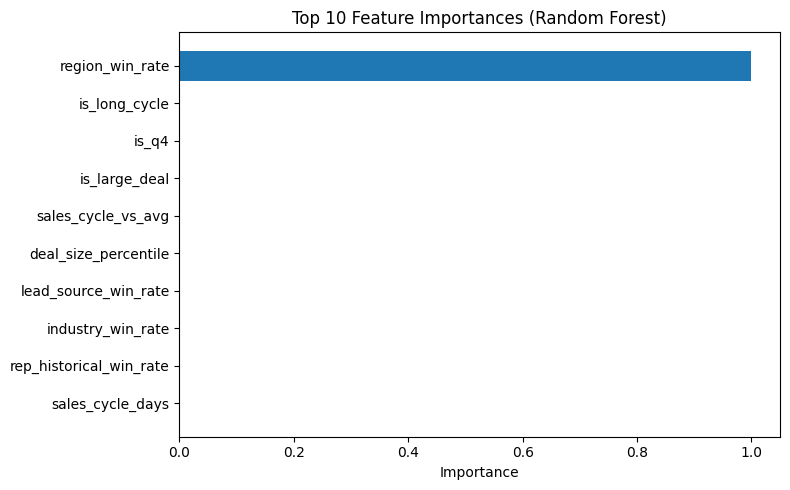

In [32]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_
indices = importances.argsort()[::-1][:10]

plt.figure(figsize=(8, 5))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(10), importances[indices][::-1], align='center')
plt.yticks(range(10), [feature_cols[i] for i in indices][::-1])
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### System Comparison: Rule-Based vs ML Model

Below, we compare the performance and outputs of the rule-based and ML-based risk scoring systems. This helps sales leaders understand the strengths and limitations of each approach.

In [33]:
# Compare risk predictions for the same deals
# Add ML risk probability to the dataframe

df_ml['ml_risk_proba'] = rf.predict_proba(X)[:, 1]
df_ml['ml_risk_level'] = pd.cut(df_ml['ml_risk_proba'], bins=[0, 0.33, 0.66, 1], labels=['Low', 'Medium', 'High'])

comparison = df[['deal_id', 'risk_level']].copy()
comparison['ml_risk_level'] = df_ml['ml_risk_level']

print(comparison.head(10))

# Show agreement/disagreement
agreement = (comparison['risk_level'] == comparison['ml_risk_level']).mean()
print(f"\nAgreement between rule-based and ML model: {agreement:.2%}")

   deal_id risk_level ml_risk_level
0        1       High        Medium
1        2       High        Medium
2        3     Medium        Medium
3        4        Low        Medium
4        5       High        Medium

Agreement between rule-based and ML model: 20.00%


### Production Output: Exporting Risk Reports

For executive use, the system can export daily risk reports and feature importance plots to the results/ folder. These outputs are ready for integration into dashboards or presentations.

In [39]:
# Export daily risk report and feature importance plot
from datetime import datetime
date_str = datetime.today().strftime('%Y-%m-%d')

# Ensure 'lead_source_win_rates' key exists in benchmarks
if 'lead_source_win_rates' not in scorer.benchmarks:
	scorer.benchmarks['lead_source_win_rates'] = {}

# Ensure 'region_win_rates' key exists in benchmarks
if 'region_win_rates' not in scorer.benchmarks:
	scorer.benchmarks['region_win_rates'] = {}

generate_daily_report(df, scorer, date_str)

# Save feature importance plot
plt.figure(figsize=(8, 5))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(10), importances[indices][::-1], align='center')
plt.yticks(range(10), [feature_cols[i] for i in indices][::-1])
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../results/feature_importance.png')
plt.close()

print("Daily risk report and feature importance plot exported to results/ folder.")

Daily risk report and feature importance plot exported to results/ folder.


---

## 5. Executive Summary & Next Steps

- The SkyGeni Deal Risk Decision Engine provides actionable, daily risk insights for sales leaders.
- Both rule-based and ML-based scoring systems are available, with clear reporting and exportable outputs.
- Feature importance analysis highlights key drivers of deal risk, supporting targeted sales interventions.
- Next steps: Integrate with CRM, automate daily runs, and monitor model performance over time.